# eda004

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
%matplotlib inline

## データセットの読み込み

In [24]:
input_path = Path("../input")

train_df = pd.read_parquet(input_path / "train.parquet")
test_df = pd.read_parquet(input_path / "test.parquet")

## EDA

datetime(日時)：日付 + 時間(1時間ごとに1data)\
season(季節)：1 = 春, 2 = 夏, 3 = 秋, 4 = 冬\
holiday(祝日)：0 = 祝日ではない, 1 = 祝日\
workingday(労働日)：0 = 休日または休暇, 1 = 労働日\
weather(天気)：\
1: 快晴, 雲が少ない, 部分的に曇り, 部分的に曇り\
2：霧＋曇り、霧＋雲切れ、霧＋雲少、霧\
3: 小雪、小雨+雷雨+雲が散らばる、小雨+雲が散らばる\
4：大雨＋氷霰＋雷雨＋霧、雪＋霧\
temp(気温)：摂氏温度\
atemp(体感気温)：摂氏の感じる温度\
humidity(湿度)：相対湿度\
windspeed(風速)：風速\
casual(非登録ユーザーの利用数)：非登録ユーザーの利用数\
registered(登録ユーザーの利用数)：登録ユーザーの利用数\
count(総利用数)：総利用数


In [25]:
datetime = pd.to_datetime(train_df["datetime"])

train_df["year"] = datetime.dt.year
train_df["month"] = datetime.dt.month
train_df["day"] = datetime.dt.day
train_df["hour"] = datetime.dt.hour
train_df["dayofweek"] = datetime.dt.day_name()


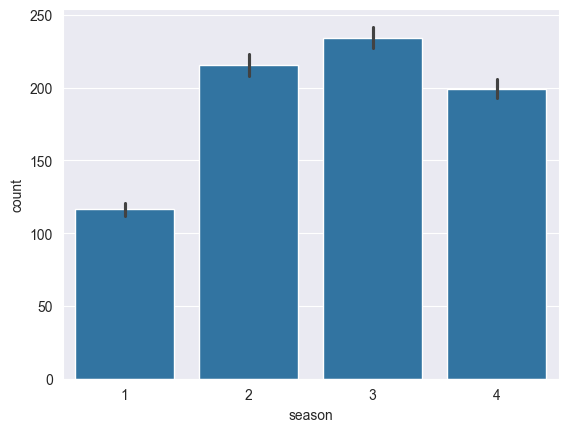

In [31]:
sns.barplot(x="season", y="count", data=train_df)
plt.show()

season=2, 3が多い。\
ということは、夏と秋に多く利用されている。

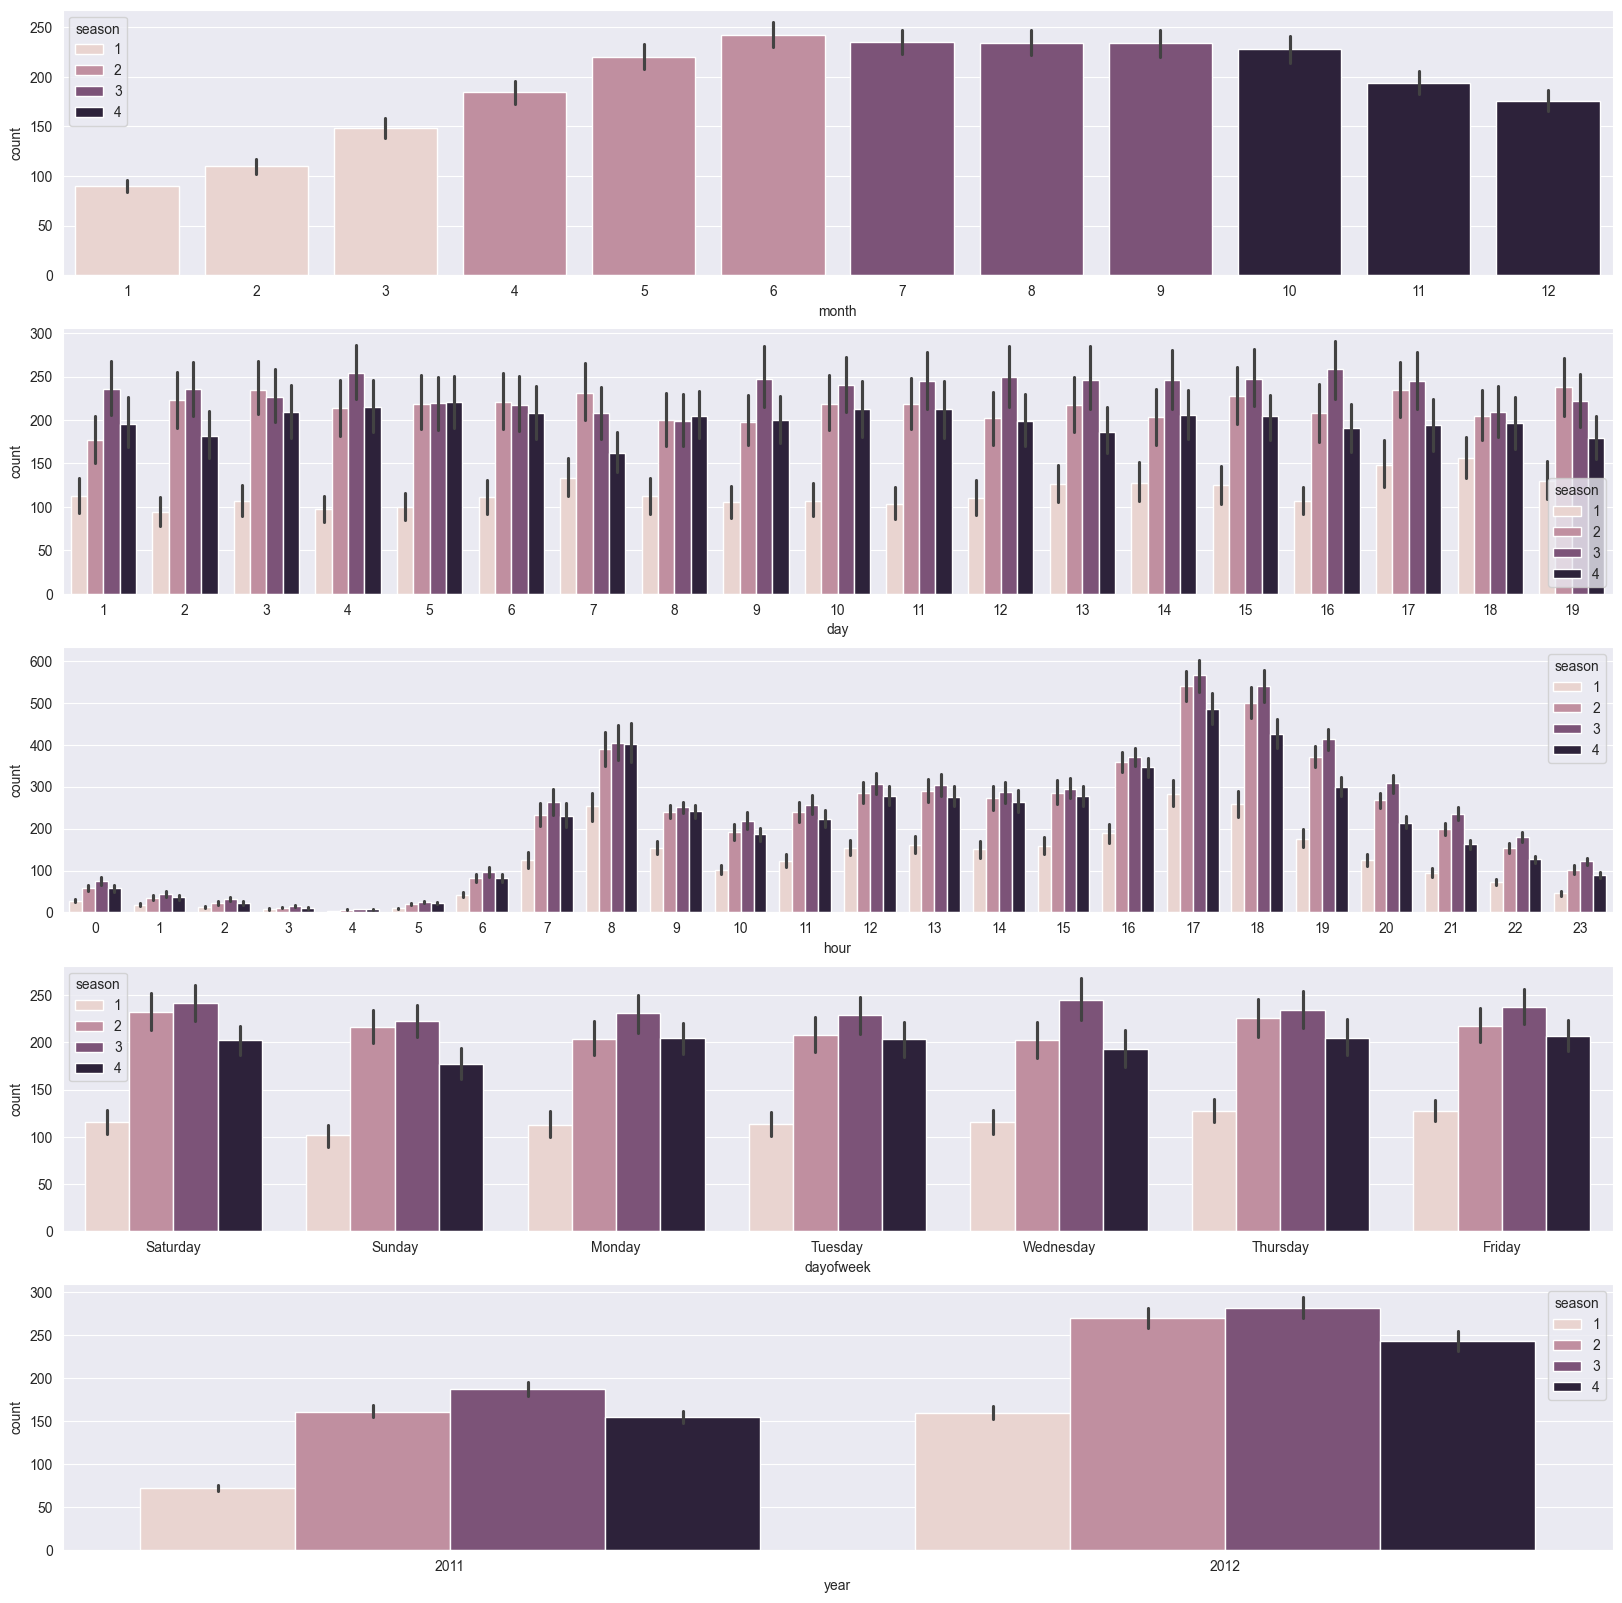

In [64]:
fig, axes = plt.subplots(5, 1, figsize=(20, 20))
sns.barplot(x="month", y="count", hue="season", data=train_df, ax=axes[0])
sns.barplot(x="day", y="count", hue="season", data=train_df, ax=axes[1])
sns.barplot(x="hour", y="count", hue="season", data=train_df, ax=axes[2])
sns.barplot(x="dayofweek", y="count", hue="season", data=train_df, ax=axes[3])
sns.barplot(x="year", y="count", hue="season", data=train_df, ax=axes[4])
plt.show()

2021, 2022で利用数の差はあれど、割合に差はなさそう。（要確認）\
→ 2011は秋が多くて春は少なめの傾向が見て取れた。（下セル参照）\
曜日ごとの利用数を見ると、平日の分布は結構似ている。\
土日は冬が少なくてその分夏が多い傾向にある。\
→ やはり冬は寒くて自転車に乗る人が少ないのかもしれない。\
時間と日もあまりよく分からん。

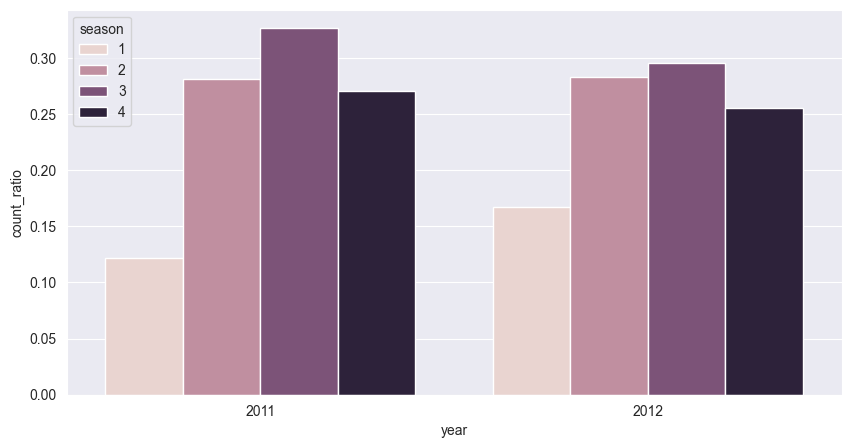

In [91]:
season_totals = train_df.groupby(['year', 'season'])['count'].sum().reset_index()
year_totals = train_df.groupby('year')['count'].sum().reset_index()

season_totals = season_totals.merge(year_totals, on='year', suffixes=('_season', '_year'))
season_totals['count_ratio'] = season_totals['count_season'] / season_totals['count_year']

figure = plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="count_ratio", hue="season", data=season_totals)
plt.show()

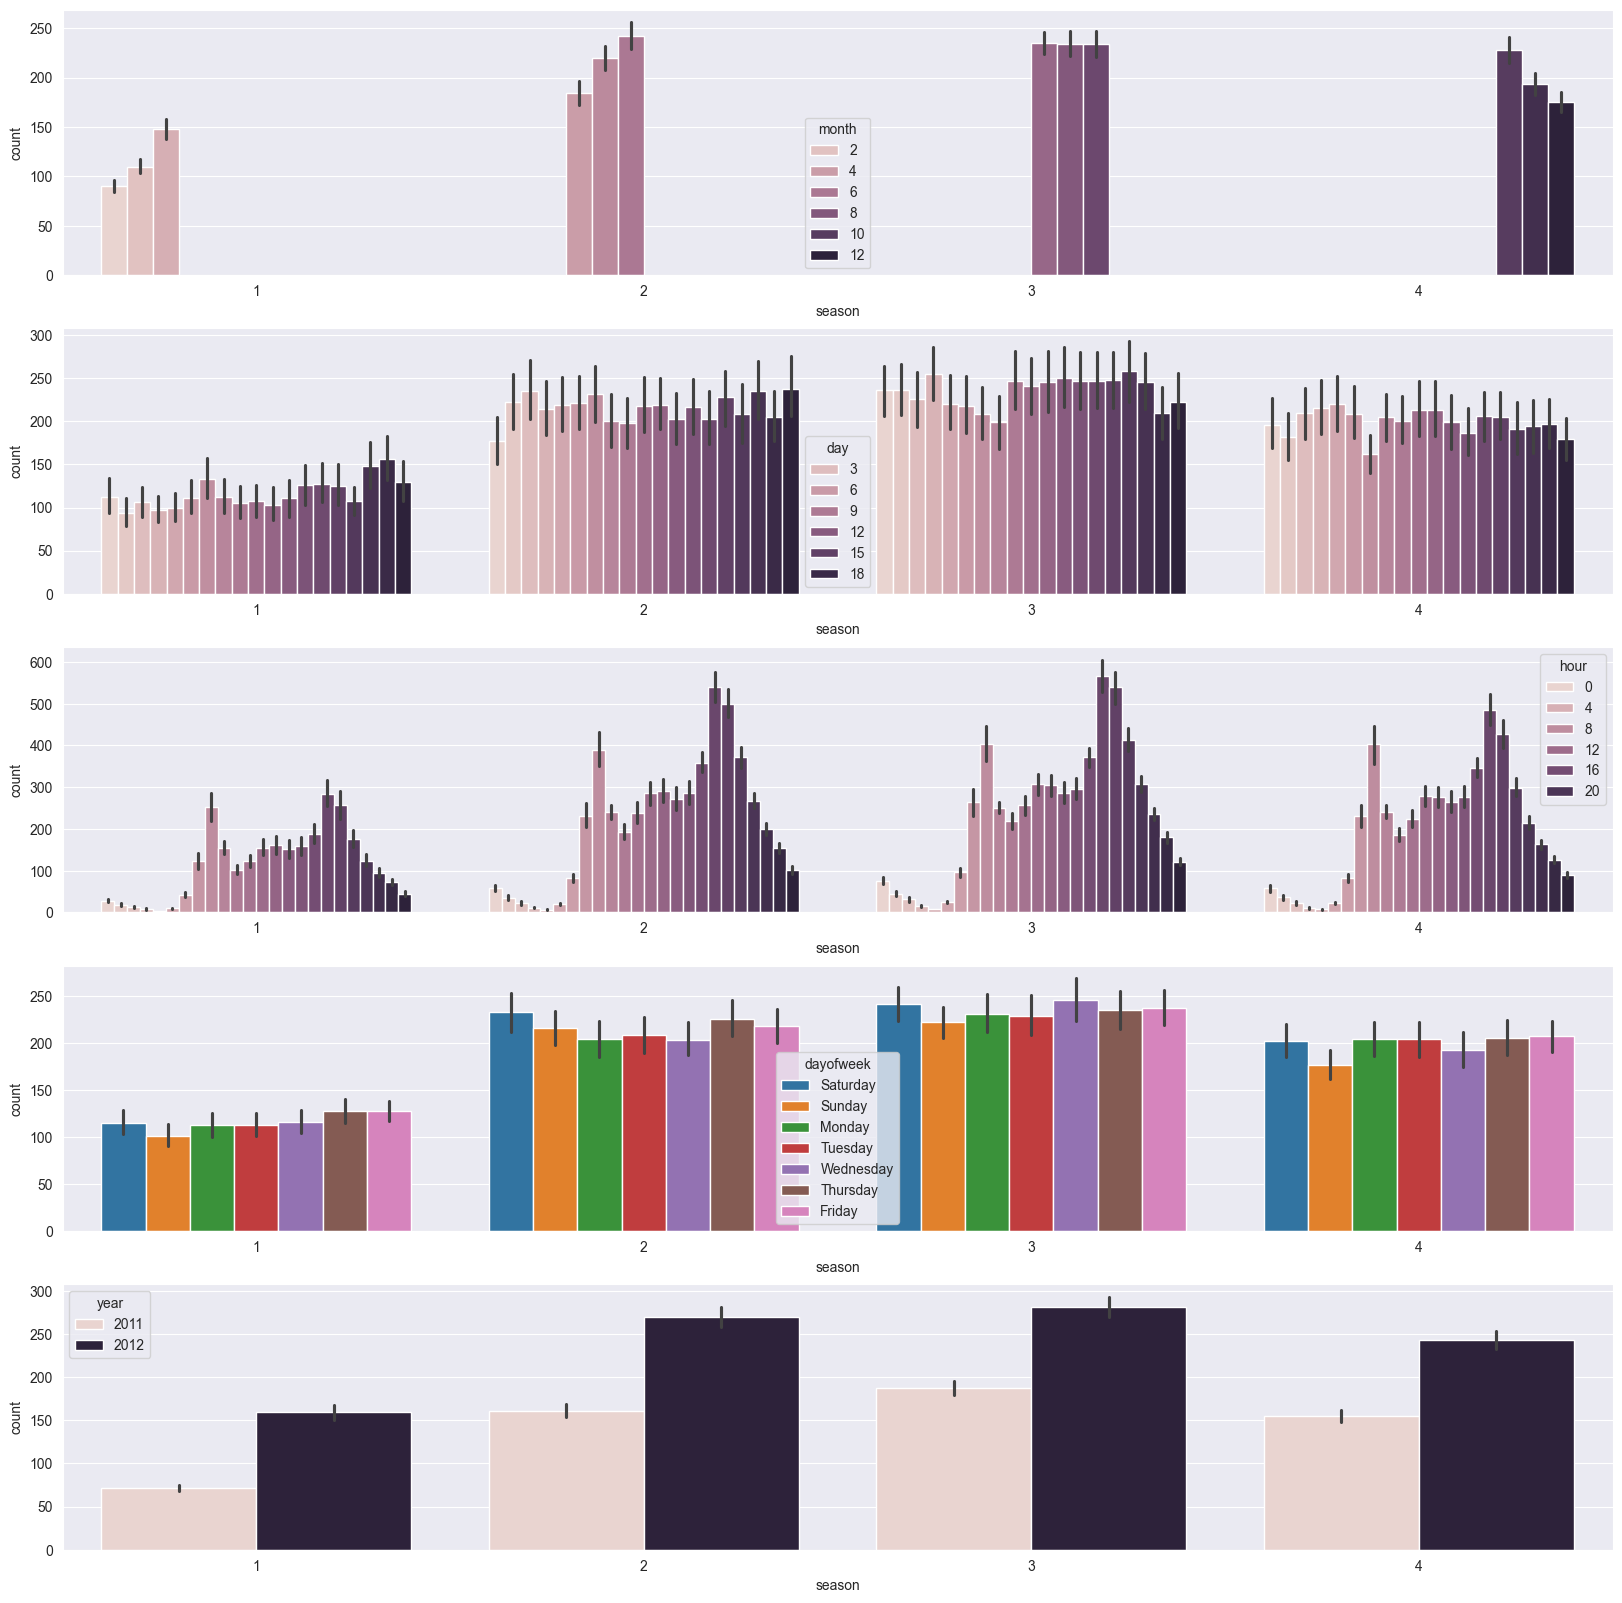

In [77]:
fig, axes = plt.subplots(5, 1, figsize=(20, 20))
sns.barplot(x="season", y="count", hue="month", data=train_df, ax=axes[0])
sns.barplot(x="season", y="count", hue="day", data=train_df, ax=axes[1])
sns.barplot(x="season", y="count", hue="hour", data=train_df, ax=axes[2])
sns.barplot(x="season", y="count", hue="dayofweek", data=train_df, ax=axes[3])
sns.barplot(x="season", y="count", hue="year", data=train_df, ax=axes[4])
plt.show()

土日と季節の関係を見ると、やはり夏が多くなって冬が少なくなる傾向はありそうだが、あまり大きな差はないように見える。\
一回、相関係数を見てみた方がいいかも。

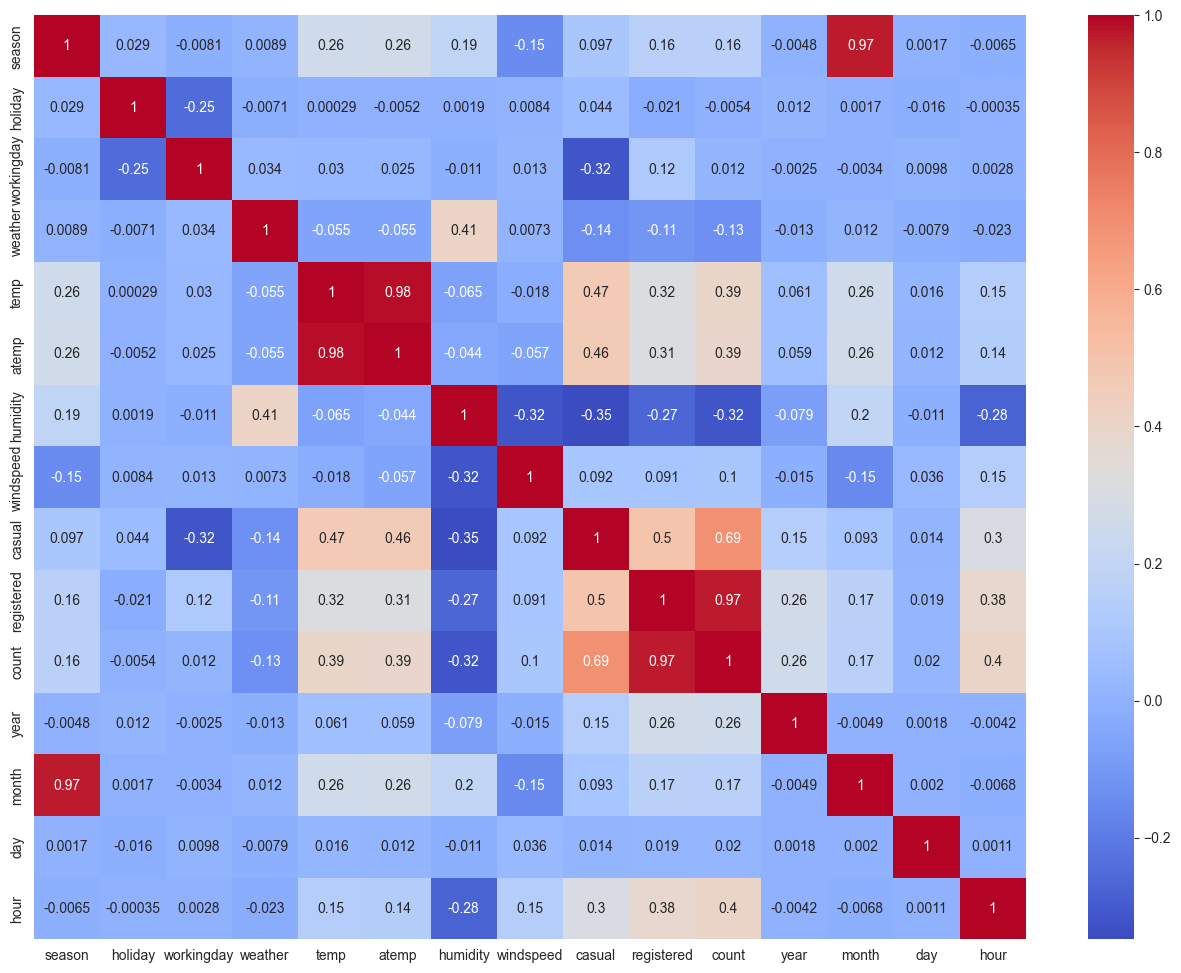

In [94]:
figure = plt.figure(figsize=(16, 12))
numeric_train_df = train_df.select_dtypes(include=[np.number])
sns.heatmap(numeric_train_df.corr(), annot=True, cmap="coolwarm")
plt.show()

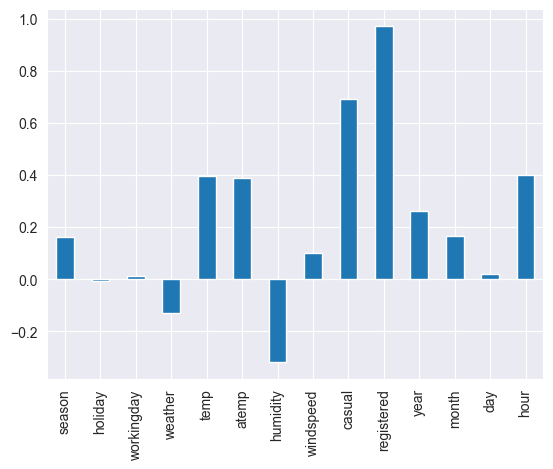

In [95]:
corr = numeric_train_df.corr()
corr_count = corr["count"]
corr_count = corr_count.drop(["count"])
corr_count.plot.bar()
plt.show()

In [80]:
corr["count"].sort_values(ascending=False)

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
day           0.019826
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

相関係数を見てみると、holidy(祝日)とworkingday(労働日)、dayはあまりcountとの相関がない。\
→ 日付に関する特徴量はあまり効かなそう。

registered(登録ユーザーの利用数)、casual(非登録ユーザの利用数)とcountは相関が高い。\
→ 確かこのカラム、テストデータになかった気がする。(なかった)

hour, temp, atemp, humidityが次点にcountとの相関が高い。\
→ hourは時間帯によって利用数が変わるので、これは使えそう。\
→ temp, atempは気温と体感気温で相関が高いので、どちらか一方でいいかも。（両方でも）\
→ humidityは湿度で、これも使えそう。

yearはそこそこという感じ。\
→ 2021, 2022で利用数の差はあれど、割合に差はなさそう。（要確認）\
　　→ 2011は秋が多くて春は少なめの傾向が見て取れた。

monthとseasonはそこそこという感じ。\
→ この二つが示すものは似てるものなので、片方でいいかも。

windspeedとweatherもそこそこという感じ。\
→ 風速の影響でレンタルするかしないか影響があるんだろうか。\
→ 天気は、晴れが多くて雨が少ない傾向があると思ってたので、相関が低いのは意外。

In [96]:
test_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
